In [1]:
#load libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import copy
import seaborn as sns
import matplotlib as mpl
from scipy import stats
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
plt.rcParams.update({'figure.max_open_warning': 0})
from matplotlib.patches import Patch
import itertools

# Table of contents <a name="contents"></a>
1. [Loading Data](#LoadingData)
2. [Classify Spatial Cells](#clinical)
3. [Cluster by Spatial Counts](#cluster1)
    1. [Cluster by scaled Composition](#clusterz)
4. [Single Variable Associations](#singlevar)
5. [Cluster by Significant Variables](#cluster2)
6. [Significance Testing](#clustersig)

##  <a name="example"></a>

# Loading Data <a name="LoadingData"></a>

### notes

Shayna used the RCB for pCR, based on Otto’s recommendation (see below), so it might be better to use that one to say consistent.

“Using the RCB definition might be better given its aligned with the study primary objectives and does provide us with information about pathology response in the breast and nodes.
RCB 0 stands for pCR; RCB-1 minimal residual disease. When performing the analyses we could also consider looking at RBC 0 and 1 combined given it’s a readout of excellent response to therapy.”

[contents](#contents)


In [87]:
#set location of files (download data and then specify location)
rootdir = r'/mnt/c/Users/engje/Documents/Data/2020/20200706_NP001-36'
# go to location of files
os.chdir(rootdir)
#os.listdir()

In [90]:
os.chdir('HER2_heterogeneity_2021/cycIF')

In [98]:
#load neighbor data
s_pos_name = 'NP001-36_75um'#'NP001-36_HER2B-TMAs'

s_date = '20201030_l'
#os.mkdir(s_date)
s_date_data = '20201023'
#df_data = pd.read_csv(f'./{s_date_data}_{s_pos_name}_NeighborhoodCounts.csv',index_col=0)
df_data = pd.read_csv(f'./{s_date_data}_{s_pos_name}_NeighborhoodCounts_1.csv',index_col=0).append(pd.read_csv(f'./{s_date_data}_{s_pos_name}_NeighborhoodCounts_2.csv',index_col=0))
print(f'Loaded {s_date_data}_{s_pos_name}_NeighborhoodCounts.csv')
df_data['Sample'] = [item.split('_')[0] for item in df_data.index]
df_data['countme'] = True
#df_data.dtypes
#set(df_data.slide)

Loaded 20201023_NP001-36_75um_NeighborhoodCounts.csv


In [83]:
#load gated data
s_pos_name = 'NP001-36_edge31'#'NP001-36_HER2B-TMAs'
s_date_gate = '20201023'
df_gate = pd.read_csv(f'./{s_date_data}_{s_pos_name}_GatedPositiveCellNames_1.csv',index_col=0).append(pd.read_csv(f'./{s_date_data}_{s_pos_name}_GatedPositiveCellNames_2.csv',index_col=0))
print(f'Loaded {s_date_data}_{s_pos_name}_GatedPositiveCellNames.csv')
df_gate['Sample'] = [item.split('_')[0] for item in df_gate.index]
df_gate['countme'] = True
print(len(df_gate))

Loaded 20201023_NP001-36_edge31_GatedPositiveCellNames.csv
1001535


In [95]:
#leave out edge
#df_edge = pd.read_csv('20201024_NP036_edge62_CentroidXY.csv',index_col=0)
df_edge = pd.read_csv('20201024_NP036_edge308_CentroidXY.csv', index_col=0)

# take out edge
df_data = df_data[(~df_data.index.isin(df_edge.index)) & (~df_data.Sample.isin(['NP015']))] #,'NP015: high tissue loss in stroma; may need to analyze tissue loss in detail

In [97]:
df_data.iloc[:350000].to_csv(f'{s_date_data}_{s_pos_name}_NeighborhoodCounts_1.csv')
df_data.iloc[350000:].to_csv(f'{s_date_data}_{s_pos_name}_NeighborhoodCounts_2.csv')

In [96]:
print(len(df_data)/2)

345305.5


In [9]:
# run once: combine neighbor counts and gated celltypes
if not df_data.columns.str.contains('celltype').any():
    df_data = df_data.merge(df_gate.loc[:,['celltype','CellProlif','ImmuneType','HRStatus']],left_index=True,right_index=True)

In [10]:
#load annotation
df_annot = pd.read_csv('./NP001-36.csv',index_col=0, dtype={'HMS':'str','Site_Core':'str','DF':'int'})
df_annot.index = [item.replace('_','-') for item in df_annot.index]

In [11]:
df_outcome = pd.read_csv('patients1_20.csv',index_col=0)
df_outcome.columns[df_outcome.columns.str.contains('pCR')]
#for s_index in df_outcome.index:
#    df_annot.loc[df_annot.DF==s_index,'pCR'] = int(df_outcome.loc[s_index,'pCR_breastANDaxilla'])
#df_annot = df_annot.astype({'pCR':'int'})
# add to dataframe
for s_sample in df_annot.index:
    df_data.loc[df_data.Sample==s_sample,'Patient'] = int(df_annot.loc[s_sample,'DF'])

In [12]:
'''
df_outcome.columns[df_outcome.columns.str.contains('pCR')]
#funny cases
df_outcome.loc[df_outcome.loc[:,['pCR_breast', 'pCR_breast2', 'pCR_breastnoDCIS', 'pCR_axilla','pCR_breastANDaxilla']].sum(axis=1) == 0,'pCR_ba_noDCIS'] = int(0)
df_outcome.loc[df_outcome.loc[:,['pCR_breast', 'pCR_breast2', 'pCR_breastnoDCIS', 'pCR_axilla','pCR_breastANDaxilla']].sum(axis=1) != 0,'pCR_ba_noDCIS'] = int(1)
df_outcome = df_outcome.astype({'pCR_ba_noDCIS':'int'})
'''
# use RCB
df_outcome.loc[df_outcome.loc[:,'RCB'] < 2,'pCR_RCB'] = int(0)
df_outcome.loc[df_outcome.loc[:,'RCB'] >=2,'pCR_RCB'] = int(1)
df_outcome = df_outcome.astype({'pCR_RCB':'int'})
#df_outcome.loc[:,['RCB','pCR_RCB']]

In [13]:
# color of Pcr
s_pcr = 'pCR_breastANDaxilla'
s_pcr = 'pCR_RCB'
lut_pcr = dict(zip([0,1],cm.tab10.colors))

In [14]:
#average number of neighbors
df_data.loc[:,df_data.columns[(df_data.dtypes=='float64') & (df_data.columns!='Patient')]].sum(axis=1).mean()

100.41811381515788

# Classify Cell Types in Spatial Data <a name="clinical"></a>

[contents](#contents)

In [15]:
d_cell = {'immune':['CD20Bcell','CD4Tcell_FoxP3', 'CD4Tcell_FoxP3_prolif', 'CD4Tcell_GRNZB',
       'CD4Tcell_PD1', 'CD4Tcell_PD1_prolif', 'CD4Tcell', 'CD4Tcell_prolif',
       'CD8Tcell_FoxP3', 'CD8Tcell_GRNZB', 'CD8Tcell_PD1', 'CD8Tcell',
       'CD8Tcell_prolif', 'MyeloidImmune_GRNZB', 'MyeloidImmune_PD1',
       'MyeloidImmune', 'MyeloidImmune_prolif'],
        'stromal':['stromal_PDPN', 'stromal_Vim', 'stromal_Vim_PDPN', 'stromal_Vim_aSMA',
       'Other_NonTumor', 'stromal_aSMA'],
       'tumor':['Bas_HER2', 'Bas_TN', 'Lum_Bas_ER', 'Lum_Bas_HER2', 'Lum_Bas_Mes_TN',
       'Lum_Bas_TN', 'Lum_EGFR_HER2', 'Lum_EGFR_TN', 'Lum_ER', 'Lum_ER_HER2',
       'Lum_HER2', 'Lum_Mes_HER2', 'Lum_Mes_TN', 'Lum_TN'],
         'endothelial':['endothelial','stromal_aSMA']}

In [16]:
#df_data.dtypes=='float64'

# Cluster by cell type proximities, color by pcr <a name="cluster1"></a>

For data exploration, I started by clustering the samples by the cell counts of different proximities.

- Tumor to tumor, immune, stroma, endothelial

- Immune to immune, stroma and endothelial

- Endothelial to endothelial, stroma

- Stroma to stroma

[contents](#contents)

In [17]:
#[print(item) for item in itertools.combinations_with_replacement(['tumor','immune','endothelial','stromal'],2)]
#[f'{s_center}_to_{item}' for item in df_prop.columns]

In [19]:
#heatmaps
mpl.rcParams.update({'font.size': 16})
s_grouper = 'Patient'
for item in itertools.combinations_with_replacement(['tumor','immune','endothelial','stromal'],2):
    print(item)
    s_center = item[0]
    s_target = item[1]
    ls_targets = d_cell[s_target]
    #log2 transform
    df_cell = np.log2(df_data.loc[df_data.celltype==s_center,ls_targets].fillna(0) + 1)
    df_cell[s_grouper] = df_data.loc[df_data.celltype==s_center,s_grouper]
    df_prop = df_cell.groupby(s_grouper).sum()/df_cell.groupby(s_grouper).count()
    for s_index in df_prop.index:
        df_prop.loc[s_index, 'ID'] = int(df_outcome.loc[s_index,s_pcr]) 
    species = df_prop.pop("ID")
    row_colors = species.map(lut_pcr)
    df_plot = df_prop.fillna(0)
    df_plot.columns  = [f'{s_center}_to_{item}' for item in df_prop.columns]
    g = sns.clustermap(df_plot,figsize=(8,10),cmap='viridis',row_colors=row_colors,cbar_kws={'label':'log2(neigh +1)'},tree_kws=dict(linewidths=1.5))
    handles = [Patch(facecolor=lut_pcr[name]) for name in lut_pcr]
    plt.legend(handles, lut_pcr, title=s_pcr,
           bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')
    plt.title(f'{s_center} to {s_target}')
    #g.savefig(f'./{s_date}/{s_center}_to_{s_target}_heatmap_pcr.png',dpi=150)
    if item == ('tumor','tumor'):
        print(df_plot.index[g.dendrogram_row.reordered_ind])
    plt.close()

('tumor', 'tumor')
Float64Index([ 3.0, 20.0,  7.0, 18.0,  4.0, 10.0, 17.0,  2.0, 16.0,  8.0, 12.0,
              15.0, 11.0,  9.0,  6.0, 19.0,  5.0, 13.0,  1.0, 14.0],
             dtype='float64', name='Patient')
('tumor', 'immune')
('tumor', 'endothelial')
('tumor', 'stromal')
('immune', 'immune')
('immune', 'endothelial')
('immune', 'stromal')
('endothelial', 'endothelial')
('endothelial', 'stromal')
('stromal', 'stromal')


## Zcore the cell types <a name="clusterz"></a>

Z scoring makes rare cell types more influential

[contents](#contents)

In [20]:
#heatmaps
s_grouper = 'Patient'
df_pcr = pd.DataFrame(index=df_outcome.index)
for item in itertools.combinations_with_replacement(['tumor','immune','endothelial','stromal'],2):
    print(item)
    s_center = item[0]
    s_target = item[1]
    ls_targets = d_cell[s_target]
    df_cell = np.log2(df_data.loc[df_data.celltype==s_center,ls_targets].fillna(0) + 1)
    df_cell[s_grouper] = df_data.loc[df_data.celltype==s_center,s_grouper]
    df_prop = df_cell.groupby(s_grouper).sum()/df_cell.groupby(s_grouper).count()
    for s_index in df_prop.index:
        df_prop.loc[s_index, 'ID'] = int(df_outcome.loc[s_index,s_pcr]) 
    species = df_prop.pop("ID")
    row_colors = species.map(lut_pcr)
    df_plot = df_prop.fillna(0)
    df_plot.columns  = [f'{s_center}_to_{item}' for item in df_prop.columns]
    df_pcr = df_pcr.merge(df_plot,left_index=True,right_index=True)
    g = sns.clustermap(df_plot,figsize=(8,10),cmap='viridis',row_colors=row_colors,cbar_kws={'label':'z-score'},tree_kws=dict(linewidths=1.5),z_score=1)
    handles = [Patch(facecolor=lut_pcr[name]) for name in lut_pcr]
    plt.legend(handles, lut_pcr, title=s_pcr,
           bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')
    plt.title(f'{s_center} to {s_target}')
    plt.close()
df_pcr = df_pcr.merge(df_outcome.loc[:,s_pcr],left_index=True,right_index=True)

('tumor', 'tumor')
('tumor', 'immune')
('tumor', 'endothelial')
('tumor', 'stromal')
('immune', 'immune')
('immune', 'endothelial')
('immune', 'stromal')
('endothelial', 'endothelial')
('endothelial', 'stromal')
('stromal', 'stromal')


## Single Variable Association with pCR <a name="singlevar"></a>

Each of the celltypes were tested for single variable association with response. If a variable had a significant (p < 0.05) assosiation with response, it was used for clustering, below.

[contents](#contents)

In [21]:
#plot single variable association
mpl.rcParams.update({'font.size': 10})
ls_sig = []
ls_pos = []
for s_var in df_pcr.columns[df_pcr.dtypes=='float64']:
    #print(s_var)
    statistic, pvalue = stats.mannwhitneyu(df_pcr.loc[df_pcr.groupby(s_pcr).groups[0],s_var],df_pcr.loc[df_pcr.groupby(s_pcr).groups[1],s_var])
    #print(pvalue)
    if pvalue < 0.15:
        fig,ax = plt.subplots(dpi=200,figsize=(3,3))
        sns.boxplot(y=s_var,x=s_pcr,data=df_pcr,ax=ax,showfliers=False)
        sns.stripplot(y=s_var,x=s_pcr,data=df_pcr,ax=ax,color=".25")
        ax.set_title(f'Wilcoxon Rank Sum:\n p = {pvalue:.4f}')
        ax.set_ylabel(f'{s_var}\n log2(neigh+1)')
        plt.tight_layout()
        #fig.savefig(f'./{s_date}/MannWhitneyU_{s_var}.png')
        plt.close()
        ls_pos.append(s_var)
    if pvalue < 0.05:
        ls_sig.append(s_var)

# Cluster on significant variables <a name="cluster2"></a>

The variables that were associated with response were combined for clustering. 

[contents](#contents)

Float64Index([ 5.0, 10.0,  4.0, 20.0,  3.0,  7.0, 18.0,  2.0, 12.0, 15.0,  9.0,
               6.0, 16.0, 11.0, 19.0, 14.0, 17.0,  1.0,  8.0, 13.0],
             dtype='float64', name='Patient')


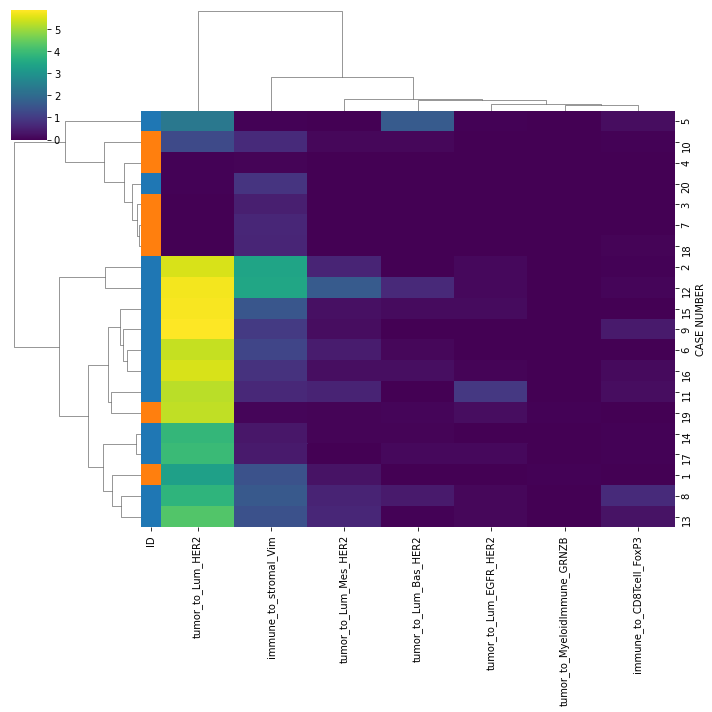

In [22]:
# better clusters p = 0.05
g = sns.clustermap(df_pcr.loc[:,ls_sig],figsize=(10,10),cmap='viridis',row_colors=row_colors)#,z_score=1)
print(df_plot.index[g.dendrogram_row.reordered_ind])
#g.savefig(f'./{s_date}/Significant_Variables_clustering_spatial.png')

Float64Index([ 1.0, 19.0,  2.0, 12.0,  3.0,  4.0, 10.0, 20.0,  7.0, 18.0,  5.0,
              14.0, 17.0,  8.0, 13.0,  6.0, 11.0, 15.0,  9.0, 16.0],
             dtype='float64', name='Patient')


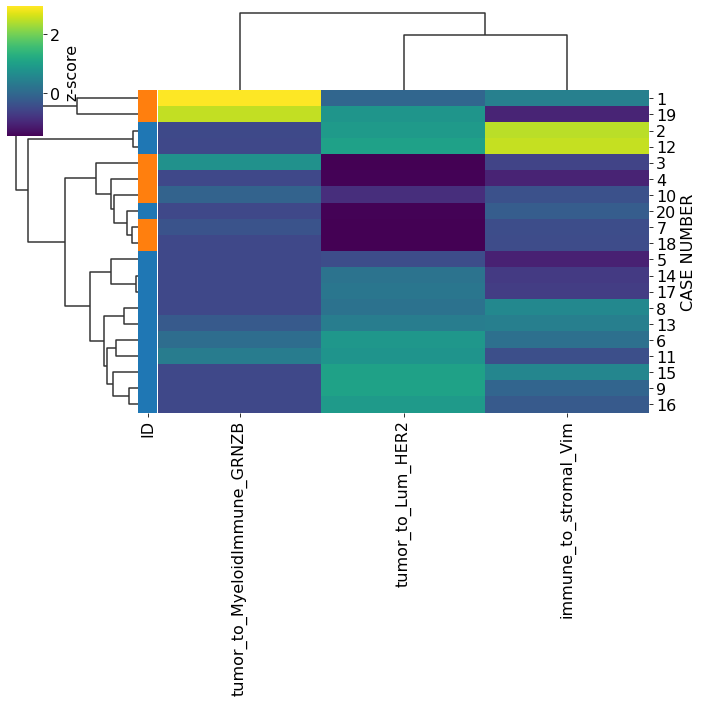

In [23]:
# better clusters p = 0.05, z
mpl.rcParams.update({'font.size': 16})
g = sns.clustermap(df_pcr.loc[:,[
 'tumor_to_Lum_HER2',
 'tumor_to_MyeloidImmune_GRNZB',
 'immune_to_stromal_Vim'
 ]],figsize=(10,10),cmap='viridis',row_colors=row_colors,z_score=1,cbar_kws={'label':'z-score'},tree_kws=dict(linewidths=1.5))
print(df_plot.index[g.dendrogram_row.reordered_ind])
#g.savefig(f'./{s_date}/Significant_Variables_clustering_spatial_z.png')

Float64Index([ 1.0, 19.0,  4.0,  3.0, 18.0,  7.0, 20.0,  2.0, 12.0,  5.0, 10.0,
              14.0,  8.0,  9.0, 13.0,  6.0, 11.0, 15.0, 16.0, 17.0],
             dtype='float64', name='Patient')


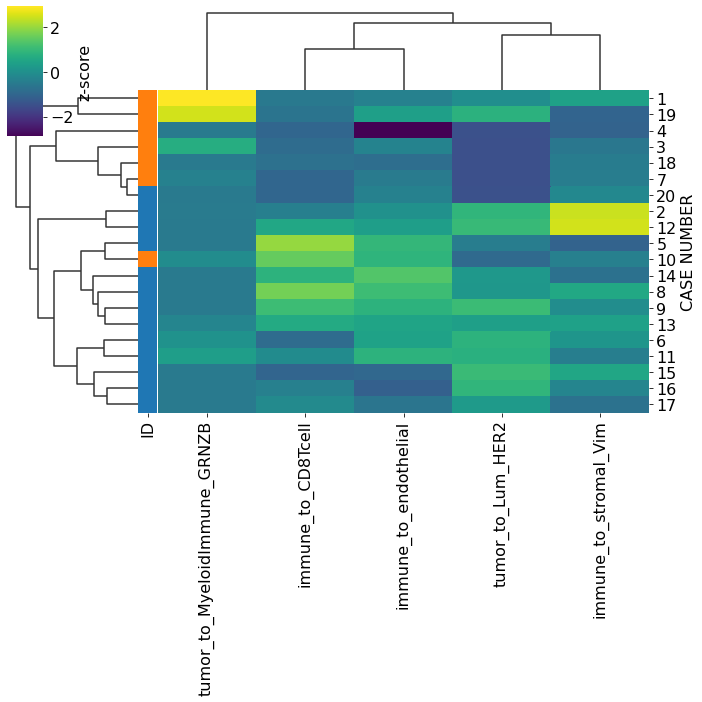

In [24]:
# better clusters p = 0.05, z
mpl.rcParams.update({'font.size': 16})
g = sns.clustermap(df_pcr.loc[:,['immune_to_CD8Tcell',
 'immune_to_endothelial',
 'tumor_to_Lum_HER2',
 'tumor_to_MyeloidImmune_GRNZB',
 'immune_to_stromal_Vim',
 #'immune_to_MyeloidImmune_prolif'
 ]],figsize=(10,10),cmap='viridis',row_colors=row_colors,z_score=1,cbar_kws={'label':'z-score'},tree_kws=dict(linewidths=1.5))
print(df_plot.index[g.dendrogram_row.reordered_ind])
#g.savefig(f'./{s_date}/Trend_Variables_clustering_spatial_z.png')

# Add Composition

In [25]:
df_comp = pd.read_csv('20201030_Composition_to_pCR.csv',index_col=0)
df_comb = df_pcr.merge(df_comp.loc[:,['HER2_in_Tum','TN_in_Tum','ER_in_Tum']],left_index=True,right_index=True)

Float64Index([ 1.0, 19.0, 20.0,  7.0, 18.0,  3.0,  4.0, 10.0, 14.0, 17.0,  6.0,
              11.0,  9.0, 12.0, 15.0, 16.0,  5.0, 13.0,  2.0,  8.0],
             dtype='float64', name='Patient')


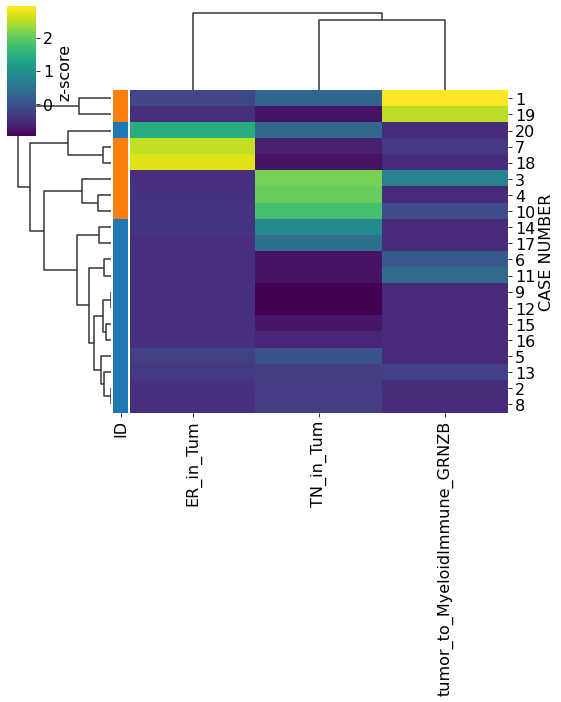

In [26]:
g = sns.clustermap(df_comb.loc[:,[#'immune_to_CD8Tcell',
 #'immune_to_endothelial',
 'TN_in_Tum','ER_in_Tum',
 'tumor_to_MyeloidImmune_GRNZB',
 #'immune_to_stromal_Vim',
 #'immune_to_MyeloidImmune_prolif'
 ]],figsize=(8,10),cmap='viridis',row_colors=row_colors,z_score=1,cbar_kws={'label':'z-score'},tree_kws=dict(linewidths=1.5))
print(df_plot.index[g.dendrogram_row.reordered_ind])
#g.savefig(f'./{s_date}/Trend_Variables_clustering_spatial_comp_z.png')

# Misclassified analysis

In [27]:
#predicted non-responders
for s_var in df_pcr.columns[df_pcr.dtypes=='float64']:
    statistic, pvalue = stats.mannwhitneyu(df_pcr.loc[[9,13],s_var],df_pcr.loc[[3,3],s_var])
    if pvalue < 0.15:
        print(s_var)
        print(pvalue)

tumor_to_Bas_HER2
0.09696542614120535
tumor_to_Bas_TN
0.11033568095992341
tumor_to_Lum_Bas_ER
0.11033568095992341
tumor_to_Lum_Bas_Mes_TN
0.11033568095992341
tumor_to_Lum_Bas_TN
0.11033568095992341
tumor_to_Lum_EGFR_HER2
0.11033568095992341
tumor_to_Lum_EGFR_TN
0.11033568095992341
tumor_to_Lum_ER
0.11033568095992341
tumor_to_Lum_ER_HER2
0.11033568095992341
tumor_to_Lum_HER2
0.11033568095992341
tumor_to_Lum_Mes_HER2
0.11033568095992341
tumor_to_Lum_TN
0.11033568095992341
tumor_to_CD4Tcell_PD1_prolif
0.11033568095992341
tumor_to_CD4Tcell
0.11033568095992341
tumor_to_CD4Tcell_prolif
0.11033568095992341
tumor_to_CD8Tcell_FoxP3
0.11033568095992341
tumor_to_CD8Tcell_GRNZB
0.11033568095992341
tumor_to_CD8Tcell_PD1
0.11033568095992341
tumor_to_CD8Tcell
0.11033568095992341
tumor_to_CD8Tcell_prolif
0.11033568095992341
tumor_to_MyeloidImmune_GRNZB
0.11033568095992341
tumor_to_MyeloidImmune_prolif
0.11033568095992341
tumor_to_endothelial
0.11033568095992341
tumor_to_stromal_aSMA_x
0.11033568095992

Float64Index([10.0,  3.0,  7.0, 18.0,  1.0, 19.0,  4.0,  5.0, 20.0,  6.0, 15.0,
              16.0, 14.0,  8.0, 11.0, 13.0,  9.0, 17.0,  2.0, 12.0],
             dtype='float64', name='Patient')


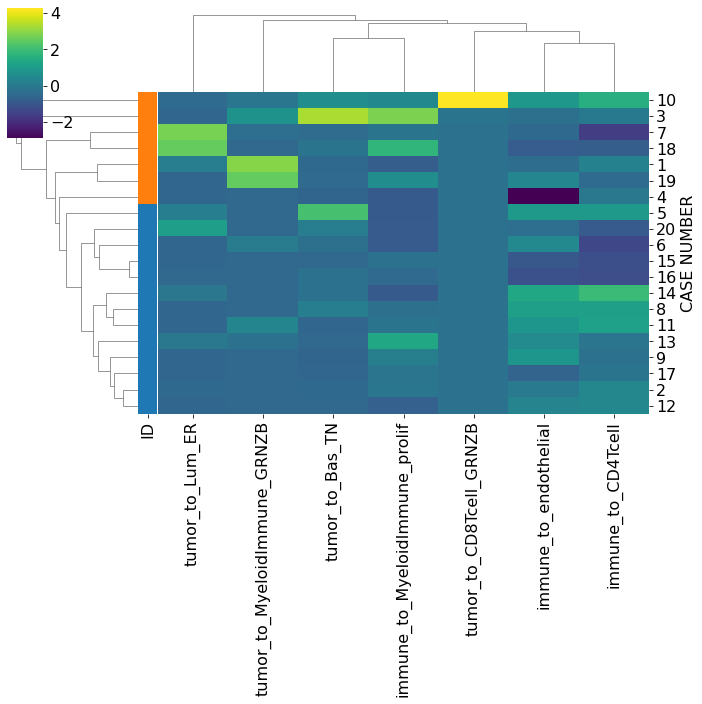

In [28]:
# better clusters custom (misclassfied analysis)
g = sns.clustermap(df_pcr.loc[:,['tumor_to_Lum_ER','tumor_to_Bas_TN',#'immune_to_stromal_PDPN','tumor_to_Lum_TN','tumor_to_Lum_EGFR_HER2',
                                 'tumor_to_CD8Tcell_GRNZB','tumor_to_MyeloidImmune_GRNZB',#'immune_to_endothelial',#'tumor_to_Lum_Bas_HER2',
                                 'immune_to_MyeloidImmune_prolif','immune_to_endothelial',
                                 'immune_to_CD4Tcell']],figsize=(10,10),cmap='viridis',row_colors=row_colors,z_score=1)
print(df_plot.index[g.dendrogram_row.reordered_ind])
#g.savefig(f'./{s_date}/Outlier_Variables_clustering_spatial_z.png')

# Significance testing <a name="clustersig"></a>

Test significance of clusters

[contents](#contents)

0.01065075452280467


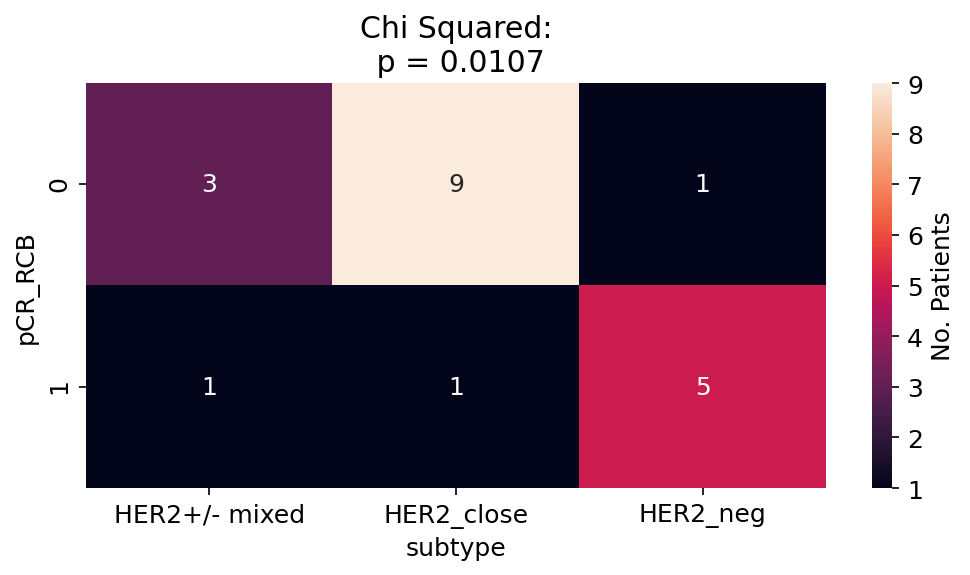

In [29]:
#('tumor', 'tumor')
mpl.rcParams.update({'font.size': 12})
g1 = [ 3.0, 20.0,  7.0, 18.0,  4.0, 10.0,]
g2 = [17.0,  2.0, 16.0,  8.0, 12.0, 15.0, 11.0,  9.0,  6.0, 19.0,]
g3 = [5.0, 13.0,  1.0, 14.0]
df_group3 = pd.DataFrame(df_pcr.loc[:,'pCR_RCB'])
df_group3.loc[g1,'subtype'] = 'HER2_neg'
df_group3.loc[g2,'subtype'] = 'HER2_close'
df_group3.loc[g3,'subtype'] = 'HER2+/- mixed'
df_group3['countme'] = True
#chi squared 
confusion_matrix = pd.crosstab(df_group3.pCR_RCB, df_group3.subtype,df_group3.countme,aggfunc='count')
chi2, pvalue, __, __  = stats.chi2_contingency(confusion_matrix)
print(pvalue)
fig,ax = plt.subplots(figsize=(7,4),dpi=150)
sns.heatmap(confusion_matrix, annot=True,ax=ax,cbar_kws={'label':'No. Patients'})
ax.set_title(f"Chi Squared:\n p = {pvalue:.4f}")
plt.tight_layout()
#fig.savefig(f'./{s_date}/Chi_square_tumor_tumor_spatial.png')

0.0020031832244305054


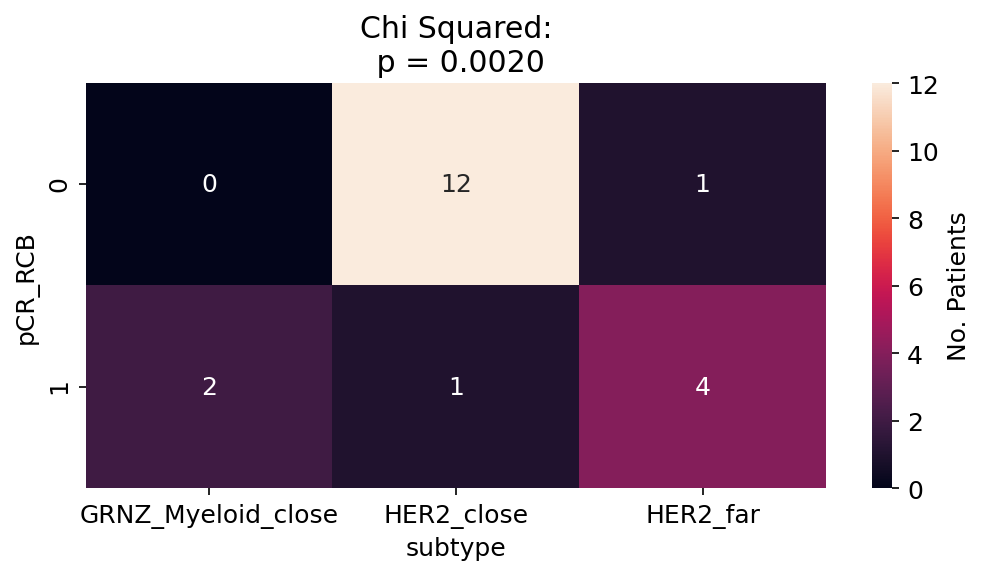

In [30]:
g1 = [ 1.0, 19.0]
g2 = [4.0,  3.0, 18.0,  7.0, 20.0]
g3 = [2.0, 12.0,  5.0, 10.0, 14.0,  8.0,  9.0, 13.0,  6.0, 11.0, 15.0, 16.0, 17.0]
df_group3 = pd.DataFrame(df_pcr.loc[:,'pCR_RCB'])
df_group3.loc[g1,'subtype'] = 'GRNZ_Myeloid_close'
df_group3.loc[g2,'subtype'] = 'HER2_far'
df_group3.loc[g3,'subtype'] = 'HER2_close'

df_group3['countme'] = True
#chi squared 
confusion_matrix = pd.crosstab(df_group3.pCR_RCB, df_group3.subtype,df_group3.countme,aggfunc='count')
confusion_matrix = confusion_matrix.fillna(0)
chi2, pvalue, __, __  = stats.chi2_contingency(confusion_matrix)
print(pvalue)
fig,ax = plt.subplots(figsize=(7,4),dpi=150)
sns.heatmap(confusion_matrix, annot=True,ax=ax,cbar_kws={'label':'No. Patients'})
ax.set_title(f"Chi Squared:\n p = {pvalue:.4f}")
plt.tight_layout()
#fig.savefig(f'./{s_date}/Chi_square_trend_spatial_clustering.png',dpi=150)

In [31]:
# sig variable (skip: no z score)
#Float64Index([ 5.0, 10.0,  4.0, 20.0,  3.0,  7.0, 18.0,  2.0, 12.0, 15.0,  9.0,
#               6.0, 16.0, 11.0, 19.0, 14.0, 17.0,  1.0,  8.0, 13.0],
#             dtype='float64', name='Patient')

0.0006838268952309557


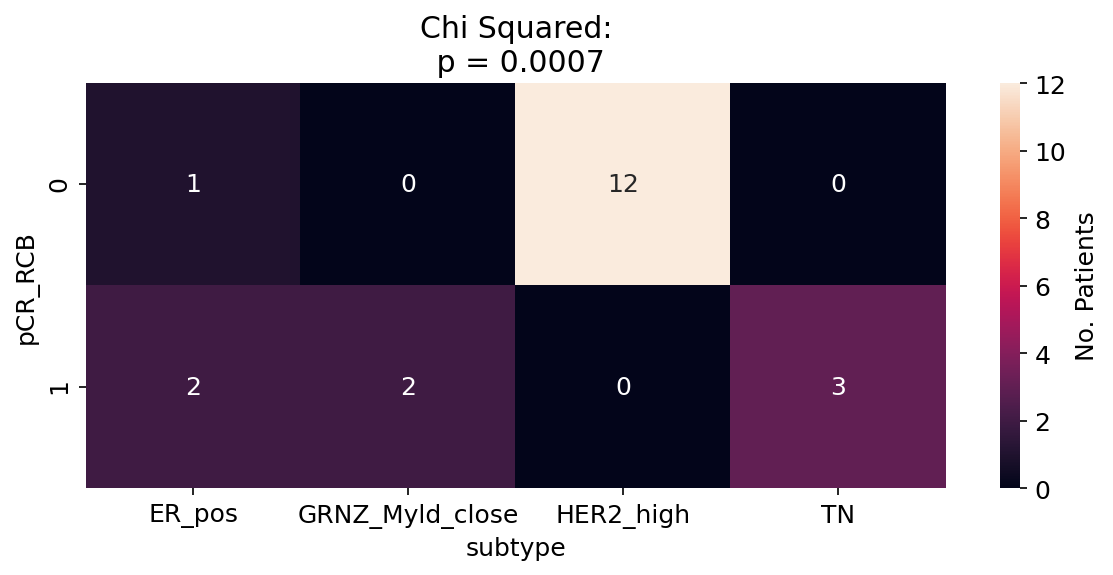

In [32]:
#combine spatial and comp
mpl.rcParams.update({'font.size': 12})
g1 = [ 1.0, 19.0,]
g2 = [20.0,  7.0, 18.0]
g3 = [3.0,  4.0, 10.0]
g4 = [14.0, 17.0,  6.0,11.0,  9.0, 12.0, 15.0, 16.0,  5.0, 13.0,  2.0,  8.0]
df_group3 = pd.DataFrame(df_pcr.loc[:,'pCR_RCB'])
df_group3.loc[g1,'subtype'] = 'GRNZ_Myld_close'
df_group3.loc[g2,'subtype'] = 'ER_pos'
df_group3.loc[g3,'subtype'] = 'TN'
df_group3.loc[g4,'subtype'] = 'HER2_high'
df_group3['countme'] = True
#chi squared 
confusion_matrix = pd.crosstab(df_group3.pCR_RCB, df_group3.subtype,df_group3.countme,aggfunc='count')
confusion_matrix = confusion_matrix.fillna(0)
chi2, pvalue, __, __  = stats.chi2_contingency(confusion_matrix)
print(pvalue)
fig,ax = plt.subplots(figsize=(8,4),dpi=150)
sns.heatmap(confusion_matrix, annot=True,ax=ax,cbar_kws={'label':'No. Patients'})
ax.set_title(f"Chi Squared:\n p = {pvalue:.4f}")
plt.tight_layout()
#fig.savefig(f'./{s_date}/Chi_square_comp_spatial_clustering.png')

0.0009671161333609586


Text(0.5, 1.0, 'p = 0.0009671161333609586')

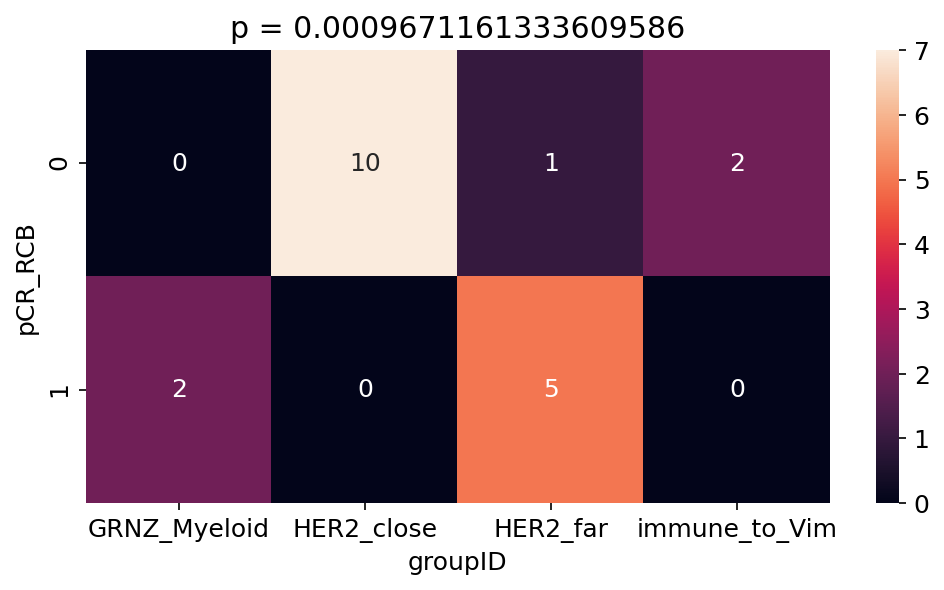

In [33]:
# sig variable , z-score
g1 = [ 1.0, 19.0,]
g2 = [2.0, 12.0,]
g3 = [3.0,  4.0, 10.0, 20.0,  7.0, 18.0,]
g4 = [5.0,14.0, 17.0,  8.0, 13.0,  6.0, 11.0, 15.0,  9.0, 16.0]
df_group3 = pd.DataFrame(df_pcr.loc[:,'pCR_RCB'])
df_group3.loc[g1,'groupID'] = 'GRNZ_Myeloid'
df_group3.loc[g2,'groupID'] = 'immune_to_Vim'
df_group3.loc[g3,'groupID'] = 'HER2_far'
df_group3.loc[g4,'groupID'] = 'HER2_close'
df_group3['countme'] = True
#chi squared 
confusion_matrix = pd.crosstab(df_group3.pCR_RCB, df_group3.groupID,df_group3.countme,aggfunc='count')
confusion_matrix = confusion_matrix.fillna(0)
chi2, pvalue, __, __  = stats.chi2_contingency(confusion_matrix)
print(pvalue)
fig,ax = plt.subplots(figsize=(8,4),dpi=150)
sns.heatmap(confusion_matrix, annot=True,ax=ax,vmin=0,vmax=7)
ax.set_title(f'p = {pvalue}')
#fig.savefig(f'./{s_date}/Chi_square_significant_spatial_clustering.png')

In [34]:
# outlier for power analysis
g1 = [10.0,  3.0,  7.0, 18.0,  1.0, 19.0,  4.0]
g2 = [5.0, 20.0,  6.0, 15.0,16.0, 14.0,  8.0, 11.0, 13.0,  9.0, 17.0,  2.0, 12.0]


In [35]:
# better clusters with z score
#import random
#g = sns.clustermap(df_pcrz.loc[:,['CD8Tcell','CD4Tcell_FoxP3','endothelial','MyeloidImmune']],figsize=(10,10),cmap='viridis',row_colors=row_colors,z_score=1)
#ls_choice = []
#ls_choice = random.choices(ls_pos,k=4)
#g = sns.clustermap(df_pcr.loc[:,ls_choice],figsize=(8,8),cmap='viridis',row_colors=row_colors,z_score=1)
##g = sns.clustermap(df_pcrz.loc[:,['HER2','immune_prolif','ER','GRNZB_immune_NT','TN']],figsize=(10,10),cmap='viridis',row_colors=row_colors,z_score=1)
#pretty good 2
#g = sns.clustermap(df_pcr.loc[:,['tumor_to_Lum_HER2','tumor_to_Lum_TN']],figsize=(8,8),cmap='viridis',row_colors=row_colors,z_score=1) 
#g.savefig(f'./{s_date}/PrettyGood_20out.png')

# Heterogeneity

In [36]:
d_data = {}

In [50]:
s_scale = 'slide'#'75um'#'20um'#
df_het = pd.read_csv(f'./NP00136-allslides-bit_entropy_{s_scale}.tsv',sep='\t',index_col=0)
#df_het = pd.read_csv('./entropy_data/NP00136-allslides-bit_entropy_spatial_radiusum75.tsv',sep='\t',index_col=0)
#df_het = pd.read_csv('./entropy_data/NP00136-allslides-bit_entropy_spatial_radiusum20.tsv',sep='\t',index_col=0)

In [51]:
#sns.clustermap(df_het,cmap='viridis')

In [52]:
#count cell types
df_data['Tumor'] = df_data.celltype=='tumor'
df_data['Immune'] = df_data.celltype=='immune'
df_data['Stromal'] = df_data.celltype=='stromal'
#df_data.head()
for s_index in df_data.Sample.unique():
    #print(s_index)
    df_het.loc[s_index,'Patient'] = df_annot.loc[s_index,'DF']
    df_het.loc[s_index,'Tumor'] = df_data.groupby('Sample').Tumor.sum().loc[s_index]
    df_het.loc[s_index,'Immune'] = df_data.groupby('Sample').Immune.sum().loc[s_index]
    df_het.loc[s_index,'Stromal'] = df_data.groupby('Sample').Stromal.sum().loc[s_index]
    df_het.loc[s_index,'Cells'] = df_data.groupby('Sample').Stromal.count().loc[s_index]
df_het.head()

,CellProlif_slide,DiffState_slide,DiffStateHRStatus_slide,HRStatus_slide,ImmuneFunc_slide,ImmuneType_slide,MainStromal_slide,StromalType_slide,Tcell_Immune_slide,TumorProlif_slide,celltype_slide,proliferation_slide,Patient,Tumor,Immune,Stromal,Cells
index,,,,,,,,,,,,,,,,,
NP001,1.672092,0.470279,2.209161,1.798828,1.561627,1.022205,0.901089,1.370408,0.787287,1.669915,1.607064,0.067523,1.0,1633.0,1075.0,3483.0,6532.0
NP002,2.204956,0.337526,1.206811,0.899115,1.815587,1.077357,1.203793,1.484341,1.134651,2.975770,1.747291,0.579416,2.0,12818.0,5318.0,11861.0,32052.0
NP003,2.449354,1.541316,1.551197,0.010868,1.989310,1.048571,0.461005,0.517436,1.149283,1.960794,1.742433,0.734043,3.0,25021.0,14136.0,23151.0,65213.0
NP004,2.111745,1.770785,1.778868,0.008726,1.524078,0.955423,0.845047,1.136011,0.953528,1.503848,1.642991,0.507908,3.0,9338.0,2733.0,9534.0,22822.0
NP005,1.416231,0.053633,0.296875,0.243543,0.491450,0.257003,0.223813,0.262199,0.361726,2.012900,1.131873,0.290303,4.0,177.0,304.0,1396.0,1888.0


In [53]:

d_counts = {'Tumor':['DiffState', 'DiffStateHRStatus','HRStatus','TumorProlif'], 
       'Immune':['ImmuneFunc', 'ImmuneType','Tcell_Immune'],
        'Stromal':['MainStromal', 'StromalType'],
        'Cells':['CellProlif','celltype', 'proliferation']}
ls_scaled_states=[]
for s_cell, ls_states in d_counts.items():
    df_sum = df_het.loc[:,[s_cell,'Patient']].groupby('Patient').sum()
    for s_state in ls_states:
        se_entropy = df_het.loc[:,f'{s_state}_{s_scale}']#*df_het.loc[:,s_cell]
        for s_index in df_data.Sample.unique():
            df_het.loc[s_index,f'{s_state}_{s_scale}'] = se_entropy.loc[s_index]*(df_het.loc[s_index,s_cell]/df_sum.loc[df_het.loc[s_index,'Patient'],s_cell])

In [54]:
df_het_pcr = df_het.drop(['Tumor','Immune','Stromal','Cells'],axis=1).groupby('Patient').sum()

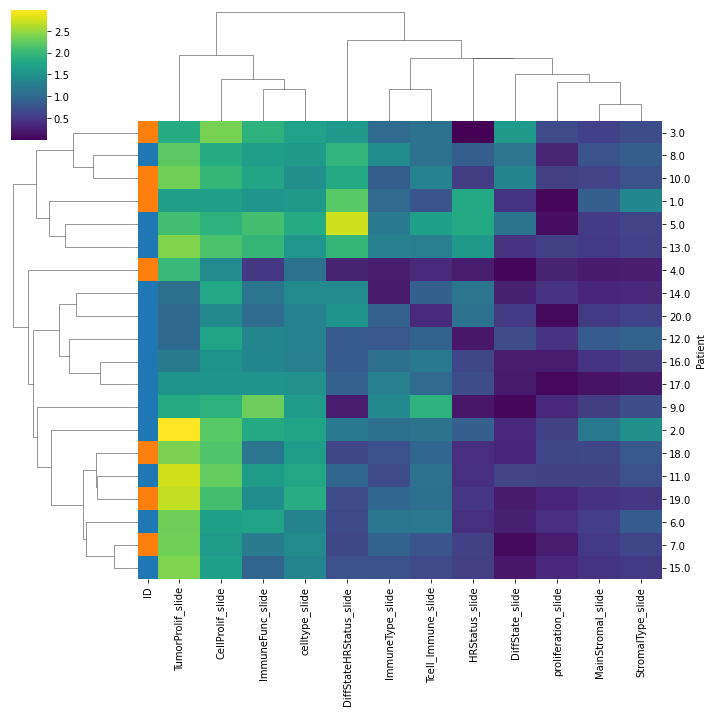

In [55]:
sns.clustermap(df_het_pcr,cmap='viridis',row_colors=row_colors) #df_het.groupby('Patient').mean()
#g.savefig(f'./{s_date}/All_het_heatmap_{s_scale}.png')

In [56]:
#df_het_pcr = df_het.groupby('Patient').mean()
df_het_pcr.loc[:,s_pcr] = df_outcome.loc[:,s_pcr]
#df_het_pcr

In [57]:
#plot single variable association
mpl.rcParams.update({'font.size': 10})
ls_sig = []
ls_pos = []
for s_var in df_het_pcr.columns[(df_het_pcr.dtypes=='float64') & (df_het_pcr.columns!='pCR_RCB')]:
    #print(s_var)
    statistic, pvalue = stats.mannwhitneyu(df_het_pcr.loc[df_het_pcr.groupby(s_pcr).groups[0],s_var],df_het_pcr.loc[df_het_pcr.groupby(s_pcr).groups[1],s_var])
    #print(pvalue)
    if pvalue < 0.2:
        fig,ax = plt.subplots(dpi=200,figsize=(3,3))
        sns.boxplot(y=s_var,x=s_pcr,data=df_het_pcr,ax=ax,showfliers=False)
        sns.stripplot(y=s_var,x=s_pcr,data=df_het_pcr,ax=ax,color=".25")
        ax.set_title(f'Wilcoxon Rank Sum:\n p = {pvalue:.4f}')
        ax.set_ylabel(f'{s_var}\n Bits')
        plt.tight_layout()
        #fig.savefig(f'./{s_date}/MannWhitneyU_{s_var}_het.png')
        ls_pos.append(s_var)
        plt.close()
    if pvalue < 0.2:
        ls_sig.append(s_var)

In [58]:
ls_sig

['HRStatus_slide', 'ImmuneType_slide', 'Tcell_Immune_slide']

In [59]:
d_data.update({s_scale:df_het_pcr})

In [60]:
ls_sig = ['HRStatus_75um', 'ImmuneType_75um','MainStromal_20um','HRStatus_slide', 'ImmuneType_slide', 'Tcell_Immune_slide'] # 20 
ls_sig = ['HRStatus_slide', 'ImmuneType_slide'] # , 'Tcell_Immune_slide'

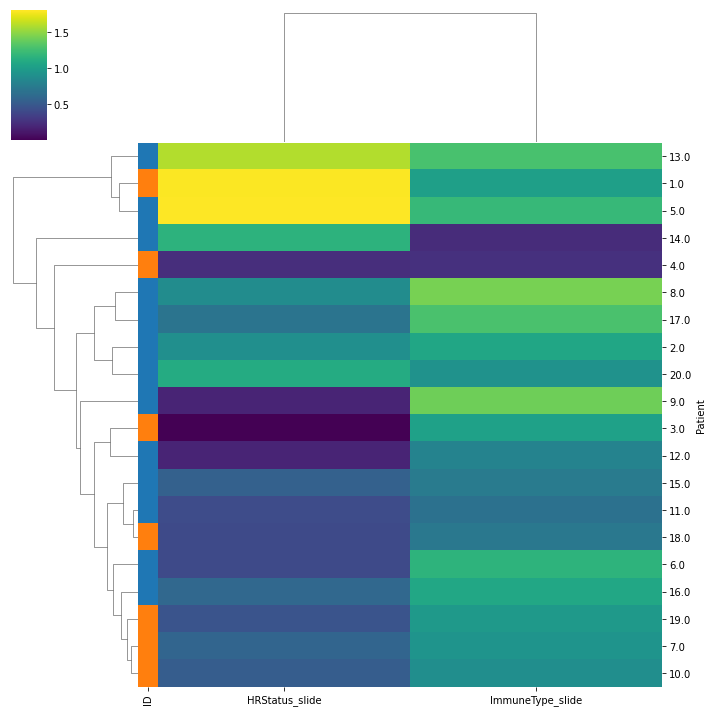

In [61]:
sns.clustermap(df_het_pcr.loc[:,ls_sig],cmap='viridis',row_colors=row_colors)
#g.savefig(f'./{s_date}/All_het_heatmap_significant.png')

# Combine Spatial, Comp and Entropy 

75 microns spatial, slide entropy

In [62]:
df_het_pcr.columns = [item.replace(s_scale,'entropy') for item in df_het_pcr.columns]

In [63]:
#df_comp.drop('pCR_RCB',axis=1).merge(df_pcr.drop('pCR_RCB',axis=1),left_index=True,right_index=True).merge(df_het_pcr,left_index=True,right_index=True).to_csv('20201102_CycIF_TDM1.csv')

In [64]:
df_combined = df_comp.drop('pCR_RCB',axis=1).merge(df_pcr.drop('pCR_RCB',axis=1),left_index=True,right_index=True).merge(df_het_pcr,left_index=True,right_index=True)

In [65]:
len(df_combined.columns[df_combined.columns.str.contains('_75um')])

0

## Correlation with HER2 <a name="HER2"></a>

Do any of the immune, stromal or tumor neighbors correlate with HER2+ high, low and negative?

[contents](#contents)

In [70]:
df_pcr['Cyc_HER2'] = df_group3['groupID']

#two
#df_pcr['Cyc_HER2'] = df_group2['groupID']

In [71]:
df_pcr.groupby('Cyc_HER2').groups

{'GRNZ_Myeloid': Index([1, 19], dtype='object', name='CASE NUMBER'),
 'HER2_close': Index([5, 6, 8, 9, 11, 13, 14, 15, 16, 17], dtype='object', name='CASE NUMBER'),
 'HER2_far': Index([3, 4, 7, 10, 18, 20], dtype='object', name='CASE NUMBER'),
 'immune_to_Vim': Index([2, 12], dtype='object', name='CASE NUMBER')}

In [72]:
#plot single variable association
s_pcr = 'Cyc_HER2'
ls_sig = []
for s_var in df_pcr.columns[df_pcr.dtypes=='float64']:
    #print(s_var)
    statistic, pvalue = stats.kruskal(df_pcr.loc[df_pcr.groupby('Cyc_HER2').groups['HER2_close'],s_var],
                                           df_pcr.loc[df_pcr.groupby('Cyc_HER2').groups['HER2_far'],s_var],
                                           #df_pcr.loc[df_pcr.groupby('Cyc_HER2').groups['HER2_neg'],s_var],
                                     )
    #print(pvalue)
    if pvalue < 0.2:
        fig,ax = plt.subplots()
        sns.boxplot(y=s_var,x=s_pcr,data=df_pcr,ax=ax)
        sns.stripplot(y=s_var,x=s_pcr,data=df_pcr,ax=ax,color=".25")
        ax.set_title(f'p= {pvalue}')
        #fig.savefig(f'./{s_date}/Kruskal_{s_var}_HER2group_spatial.png')
        plt.close()
    if pvalue < 0.05:
        ls_sig.append(s_var)


In [74]:
ls_sig

['tumor_to_Bas_HER2',
 'tumor_to_Lum_Bas_HER2',
 'tumor_to_Lum_EGFR_HER2',
 'tumor_to_Lum_HER2',
 'tumor_to_Lum_Mes_HER2',
 'immune_to_CD8Tcell_FoxP3']